# Video Denoising Pipeline
### Classical DSP vs. Deep Learning (DnCNN) — Frame-by-Frame Video Processing

This notebook builds a complete video denoising pipeline targeting the following skills:
- **Data pipeline** for training, validation, and testing
- **Classical DSP baselines**: Gaussian, Wiener, Total Variation
- **Deep learning denoiser**: DnCNN architecture in PyTorch
- **Quantitative evaluation**: PSNR & SSIM comparison
- **Video processing**: frame-by-frame inference and video reconstruction

---
**Dependencies:**
```
pip install torch torchvision numpy scipy matplotlib scikit-image opencv-python Pillow
```

In [3]:
# ── Download assets from GitHub (Colab setup) ─────────────────────────────────
import os
if not os.path.exists('clip.mp4'):
    !wget -q https://raw.githubusercontent.com/preeti-chauhan/video-denoising-pipeline/main/clip.mp4
    print('Downloaded clip.mp4')
print('Assets ready.')

Downloaded clip.mp4
Assets ready.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy import ndimage, signal
from skimage import data as skdata, color, util, restoration, filters
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.transform import resize
import cv2
import os
import warnings
warnings.filterwarnings('ignore')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')
print(f'PyTorch: {torch.__version__}')

Device: cuda
PyTorch: 2.10.0+cu128


---
## 1 · Data Pipeline

We use a real video clip (`clip.mp4`) as clean reference frames. The pipeline:
1. Extract all frames from `clip.mp4` → grayscale float32
2. Add synthetic Gaussian noise on-the-fly during training → noisy patches
3. Wrap in a `torch.utils.data.Dataset` for batched training

> **Colab:** Upload your own video to replace `clip.mp4`, or swap in any public-domain clip.

Loaded 149 clean frames — shape: (270, 480)


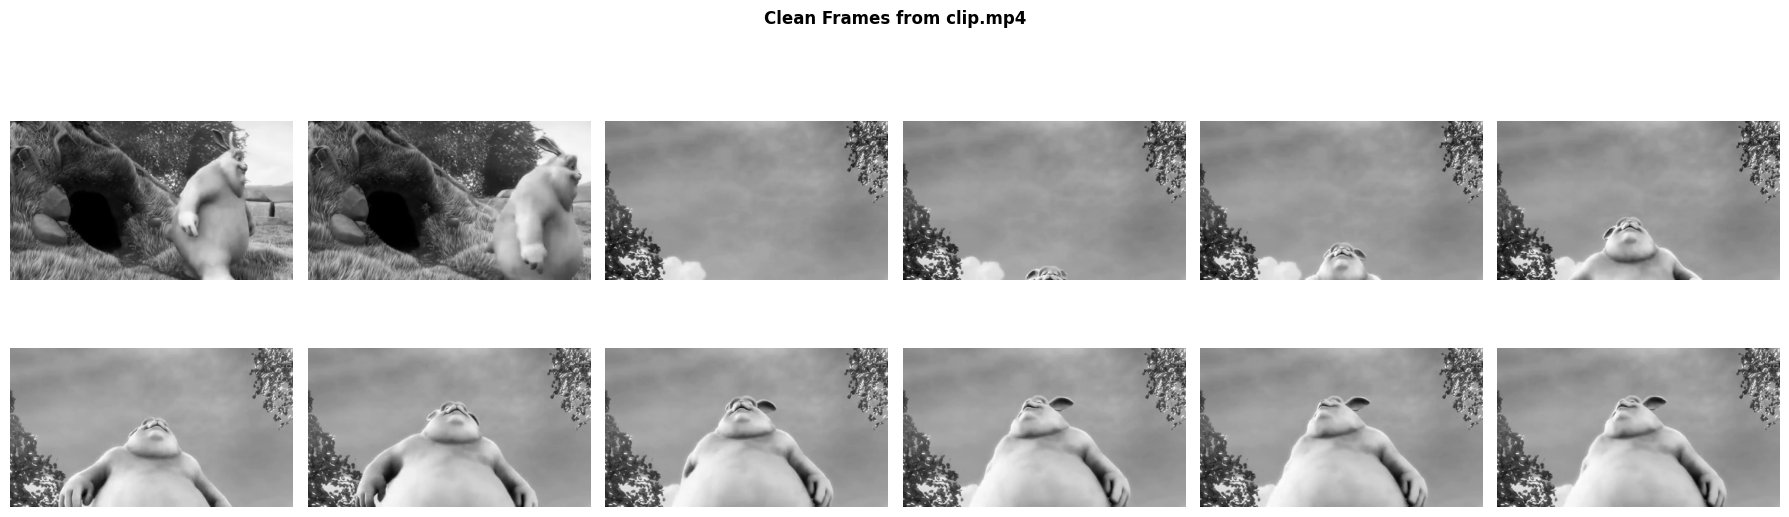

In [5]:
# ── Parameters ────────────────────────────────────────────────────────────────
NOISE_STD   = 25 / 255.0   # ← tune: noise level (25/255 is visually noticeable)
PATCH_SIZE  = 64            # ← tune: training patch size
BATCH_SIZE  = 32
NUM_EPOCHS  = 20            # ← tune: increase for better results
LR          = 1e-3

# ── Load clean frames from real video ─────────────────────────────────────────
def load_frames_from_video(path, max_frames=None):
    """Extract every frame from a video as grayscale float32."""
    cap = cv2.VideoCapture(path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
        frames.append(gray)
        if max_frames and len(frames) >= max_frames:
            break
    cap.release()
    return frames

VIDEO_PATH   = 'clip.mp4'          # 5-second Big Buck Bunny clip (public domain)
clean_frames = load_frames_from_video(VIDEO_PATH)
print(f'Loaded {len(clean_frames)} clean frames — shape: {clean_frames[0].shape}')

# Preview 12 evenly-spaced frames
idxs = [int(i * len(clean_frames) / 12) for i in range(12)]
fig, axes = plt.subplots(2, 6, figsize=(18, 6))
for ax, idx in zip(axes.flat, idxs):
    ax.imshow(clean_frames[idx], cmap='gray')
    ax.axis('off')
fig.suptitle('Clean Frames from clip.mp4', fontweight='bold')
plt.tight_layout()
plt.show()

In [6]:
class VideoDenoiseDataset(Dataset):
    """Extracts random patches from clean frames and adds Gaussian noise."""

    def __init__(self, frames, patch_size=64, patches_per_frame=50, noise_std=25/255.0):
        self.patches     = []
        self.patch_size  = patch_size
        self.noise_std   = noise_std

        for frame in frames:
            H, W = frame.shape
            for _ in range(patches_per_frame):
                r = np.random.randint(0, H - patch_size)
                c = np.random.randint(0, W - patch_size)
                patch = frame[r:r+patch_size, c:c+patch_size]
                self.patches.append(patch)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        clean = self.patches[idx]
        noise = np.random.normal(0, self.noise_std, clean.shape).astype(np.float32)
        noisy = np.clip(clean + noise, 0, 1)
        # Add channel dim: (1, H, W)
        clean_t = torch.from_numpy(clean).unsqueeze(0)
        noisy_t = torch.from_numpy(noisy).unsqueeze(0)
        noise_t = torch.from_numpy(noise).unsqueeze(0)  # DnCNN predicts noise
        return noisy_t, clean_t, noise_t

# ── Train / val / test split (149 frames: 80% / 10% / 10%) ──────────────────
n = len(clean_frames)
n_train = int(n * 0.8)
n_val   = int(n * 0.1)

train_frames = clean_frames[:n_train]
val_frames   = clean_frames[n_train:n_train + n_val]
test_frames  = clean_frames[n_train + n_val:]

train_ds = VideoDenoiseDataset(train_frames, PATCH_SIZE, patches_per_frame=50, noise_std=NOISE_STD)
val_ds   = VideoDenoiseDataset(val_frames,   PATCH_SIZE, patches_per_frame=50, noise_std=NOISE_STD)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f'Train frames: {len(train_frames)} | Val frames: {len(val_frames)} | Test frames: {len(test_frames)}')
print(f'Train patches: {len(train_ds)} | Val patches: {len(val_ds)}')

Train frames: 119 | Val frames: 14 | Test frames: 16
Train patches: 5950 | Val patches: 700


---
## 2 · Classical DSP Baselines

Before training the CNN, we establish classical denoising baselines to beat.

  Noisy input       PSNR=20.31 dB  SSIM=0.2183
  Gaussian             PSNR=28.67 dB  SSIM=0.8013
  Wiener               PSNR=29.38 dB  SSIM=0.7825
  Total Variation      PSNR=30.55 dB  SSIM=0.9007


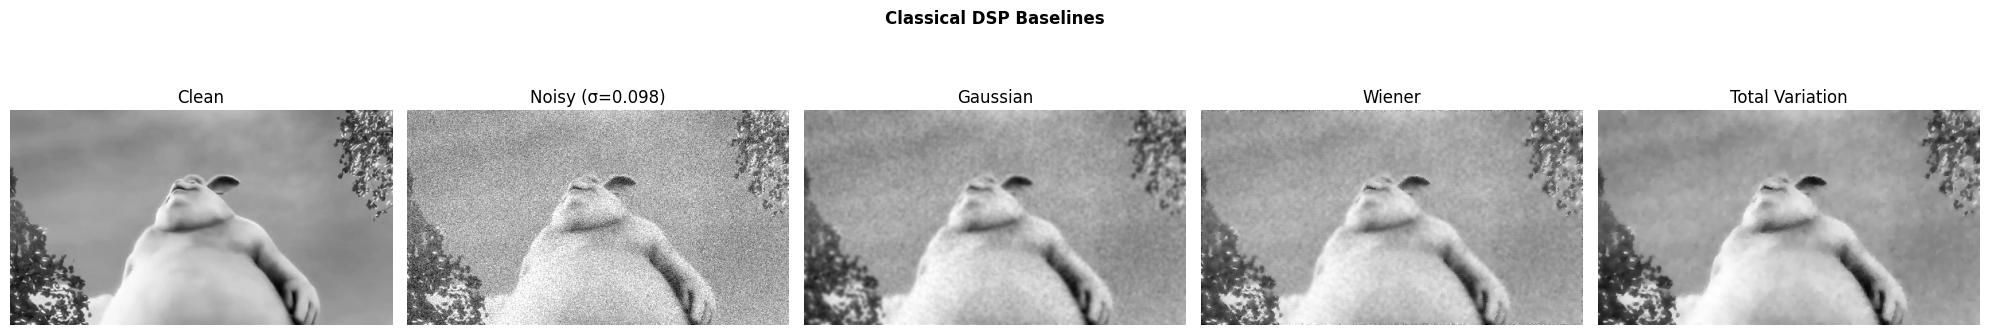

In [7]:
def add_noise(img, std=NOISE_STD):
    noise = np.random.normal(0, std, img.shape).astype(np.float32)
    return np.clip(img + noise, 0, 1)

def classical_denoise(noisy):
    return {
        'Gaussian':       filters.gaussian(noisy, sigma=1.5),
        'Wiener':         signal.wiener(noisy, mysize=5),
        'Total Variation': restoration.denoise_tv_chambolle(noisy, weight=0.1),
    }

def compute_metrics(clean, candidate):
    p = psnr(clean, candidate, data_range=1.0)
    s = ssim(clean, candidate, data_range=1.0)
    return p, s

# Evaluate on test frames
test_img   = test_frames[0]
noisy_img  = add_noise(test_img)
results    = classical_denoise(noisy_img)

print(f'  Noisy input       PSNR={compute_metrics(test_img, noisy_img)[0]:.2f} dB  SSIM={compute_metrics(test_img, noisy_img)[1]:.4f}')
for name, denoised in results.items():
    p, s = compute_metrics(test_img, denoised)
    print(f'  {name:<20} PSNR={p:.2f} dB  SSIM={s:.4f}')

# Visualize
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, (img, title) in zip(axes, [
    (test_img,  'Clean'),
    (noisy_img, f'Noisy (σ={NOISE_STD:.3f})'),
    *[(v, k) for k, v in results.items()]
]):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
fig.suptitle('Classical DSP Baselines', fontweight='bold')
plt.tight_layout()
plt.show()

---
## 3 · DnCNN — Deep Learning Denoiser

**DnCNN** (Zhang et al., 2017) uses residual learning: the network predicts
the **noise** rather than the clean image.

```
clean = noisy − DnCNN(noisy)
```

Architecture:
- **Layer 1**: Conv(64) + ReLU
- **Layers 2–(D-1)**: Conv(64) + BatchNorm + ReLU
- **Layer D**: Conv(1) — outputs predicted noise map

In [8]:
class DnCNN(nn.Module):
    """DnCNN: Beyond Gaussian Denoiser (Zhang et al., 2017)."""

    def __init__(self, depth=17, n_filters=64, kernel_size=3):
        super().__init__()
        pad = kernel_size // 2
        layers = []

        # First layer: Conv + ReLU (no BN)
        layers += [nn.Conv2d(1, n_filters, kernel_size, padding=pad, bias=False),
                   nn.ReLU(inplace=True)]

        # Middle layers: Conv + BN + ReLU
        for _ in range(depth - 2):
            layers += [nn.Conv2d(n_filters, n_filters, kernel_size, padding=pad, bias=False),
                       nn.BatchNorm2d(n_filters),
                       nn.ReLU(inplace=True)]

        # Last layer: Conv only — outputs noise map
        layers += [nn.Conv2d(n_filters, 1, kernel_size, padding=pad, bias=False)]

        self.net = nn.Sequential(*layers)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        noise_pred = self.net(x)
        return x - noise_pred          # residual: predicted clean image

model = DnCNN(depth=17).to(DEVICE)
total_params = sum(p.numel() for p in model.parameters())
print(f'DnCNN parameters: {total_params:,}')
print(model)

DnCNN parameters: 556,032
DnCNN(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Co

---
## 4 · Training Pipeline

Epoch [  5/20]  Train Loss: 0.001635  Val Loss: 0.001374  LR: 1.00e-03
Epoch [ 10/20]  Train Loss: 0.000896  Val Loss: 0.000744  LR: 5.00e-04
Epoch [ 15/20]  Train Loss: 0.000740  Val Loss: 0.000629  LR: 5.00e-04
Epoch [ 20/20]  Train Loss: 0.000668  Val Loss: 0.000603  LR: 2.50e-04


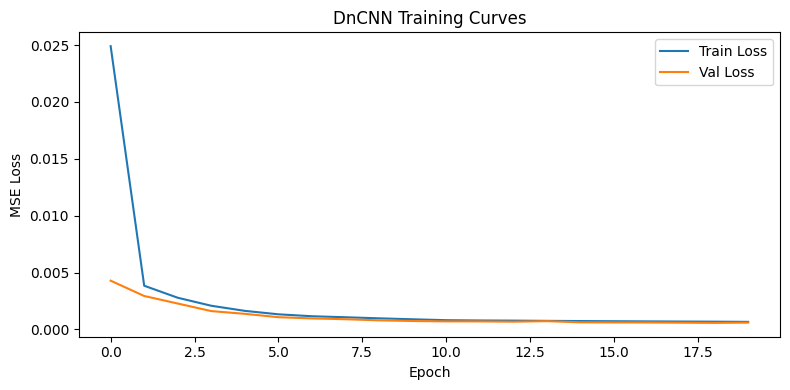

In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_losses, val_losses = [], []

for epoch in range(NUM_EPOCHS):
    # ── Train ──────────────────────────────────────────────────────────────────
    model.train()
    t_loss = 0.0
    for noisy, clean, _ in train_loader:
        noisy, clean = noisy.to(DEVICE), clean.to(DEVICE)
        optimizer.zero_grad()
        output = model(noisy)
        loss   = criterion(output, clean)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()

    # ── Validate ───────────────────────────────────────────────────────────────
    model.eval()
    v_loss = 0.0
    with torch.no_grad():
        for noisy, clean, _ in val_loader:
            noisy, clean = noisy.to(DEVICE), clean.to(DEVICE)
            output = model(noisy)
            v_loss += criterion(output, clean).item()

    t_loss /= len(train_loader)
    v_loss /= len(val_loader)
    train_losses.append(t_loss)
    val_losses.append(v_loss)
    scheduler.step()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1:>3}/{NUM_EPOCHS}]  Train Loss: {t_loss:.6f}  Val Loss: {v_loss:.6f}  LR: {scheduler.get_last_lr()[0]:.2e}')

# ── Plot loss curves ──────────────────────────────────────────────────────────
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('DnCNN Training Curves')
plt.legend()
plt.tight_layout()
plt.show()

---
## 5 · Evaluation — Classical vs. DnCNN

In [10]:
def dncnn_denoise(model, noisy_img):
    """Run DnCNN inference on a single grayscale image."""
    model.eval()
    with torch.no_grad():
        t = torch.from_numpy(noisy_img).unsqueeze(0).unsqueeze(0).to(DEVICE)
        out = model(t)
        out = out.squeeze().cpu().numpy()
    return np.clip(out, 0, 1)

print('\n=== Denoising Benchmark (test frames) ===')
print(f'{"Method":<22} {"PSNR (dB)":>10} {"SSIM":>8}')
print('-' * 42)

all_results = {}
for test_img in test_frames:
    noisy = add_noise(test_img)
    classical = classical_denoise(noisy)
    cnn_out   = dncnn_denoise(model, noisy.astype(np.float32))

    methods = {'Noisy': noisy, **classical, 'DnCNN': cnn_out}
    for name, img in methods.items():
        p, s = compute_metrics(test_img, img)
        all_results.setdefault(name, []).append((p, s))

for name, scores in all_results.items():
    avg_p = np.mean([s[0] for s in scores])
    avg_s = np.mean([s[1] for s in scores])
    print(f'{name:<22} {avg_p:>10.2f} {avg_s:>8.4f}')


=== Denoising Benchmark (test frames) ===
Method                  PSNR (dB)     SSIM
------------------------------------------
Noisy                       20.30   0.2192
Gaussian                    28.64   0.8011
Wiener                      29.38   0.7822
Total Variation             30.53   0.8962
DnCNN                       31.97   0.9038


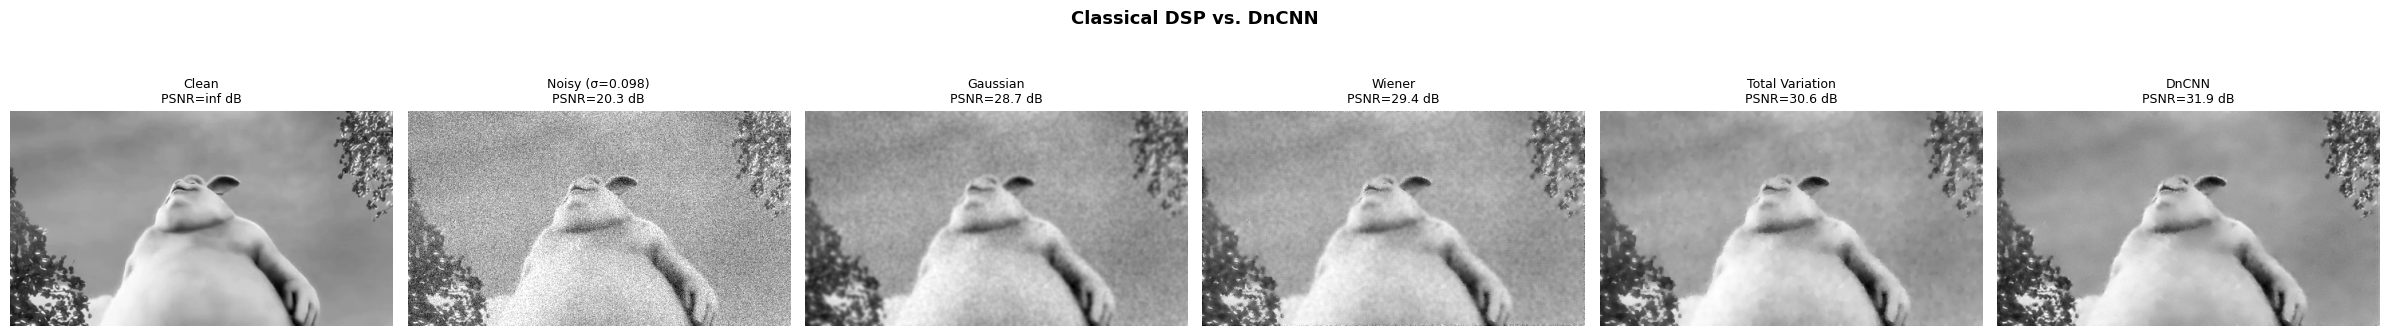

In [11]:
# ── Visual comparison on one test frame ───────────────────────────────────────
test_img  = test_frames[0]
noisy_img = add_noise(test_img)
classical = classical_denoise(noisy_img)
cnn_out   = dncnn_denoise(model, noisy_img.astype(np.float32))

imgs   = [test_img, noisy_img, *classical.values(), cnn_out]
titles = ['Clean', f'Noisy (σ={NOISE_STD:.3f})', *classical.keys(), 'DnCNN']

fig, axes = plt.subplots(1, len(imgs), figsize=(4 * len(imgs), 4))
for ax, img, title in zip(axes, imgs, titles):
    p, s = compute_metrics(test_img, img)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'{title}\nPSNR={p:.1f} dB', fontsize=9)
    ax.axis('off')
fig.suptitle('Classical DSP vs. DnCNN', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 6 · Video Processing Pipeline

Apply the trained DnCNN frame-by-frame to a video.
- **Option A**: Use the synthetic video generated below
- **Option B**: Swap in your own `.mp4` path

Noisy video saved: synthetic_noisy.mp4


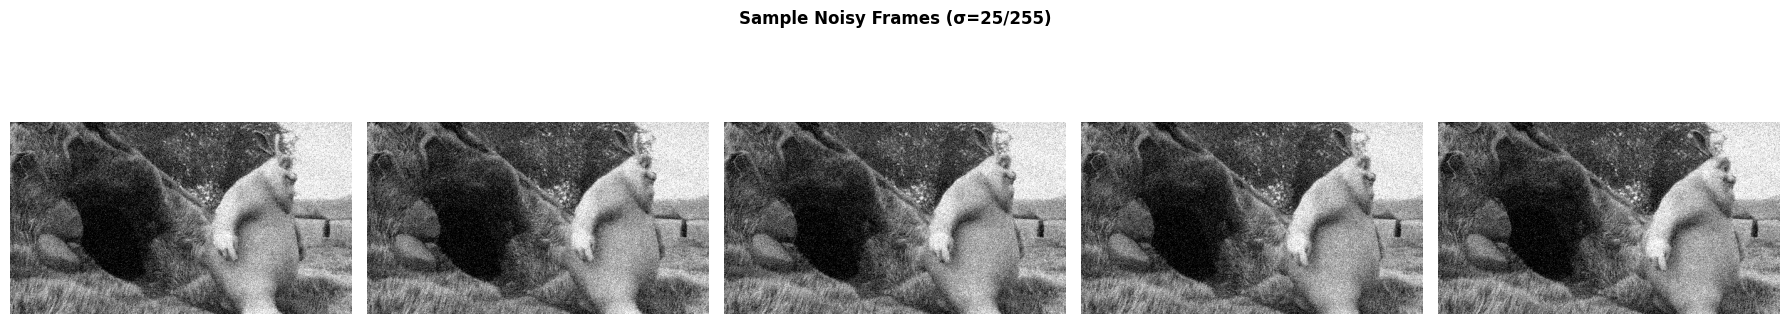

In [12]:
# ── Generate synthetic noisy video from clip.mp4 ──────────────────────────────
SYNTHETIC_VIDEO  = 'synthetic_noisy.mp4'
DENOISED_VIDEO   = 'denoised_output.mp4'
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
W   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()

# Write noisy MP4 (H.264 — plays in browser on GitHub)
tmp_noisy = '/tmp/noisy_raw.mp4'
out_noisy = cv2.VideoWriter(tmp_noisy,
                             cv2.VideoWriter_fourcc(*'mp4v'),
                             fps, (W, H), isColor=False)

noisy_frames_preview = []
cap = cv2.VideoCapture(VIDEO_PATH)
while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray  = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    noisy = np.clip(gray + np.random.normal(0, NOISE_STD, gray.shape).astype(np.float32), 0, 1)
    out_noisy.write((noisy * 255).astype(np.uint8))
    if len(noisy_frames_preview) < 5:
        noisy_frames_preview.append(noisy)
cap.release()
out_noisy.release()

# Re-encode with ffmpeg for proper H.264/AAC so GitHub can play it
os.system(f'ffmpeg -y -i {tmp_noisy} -vcodec libx264 -crf 23 -pix_fmt yuv420p {SYNTHETIC_VIDEO} -loglevel quiet')
print(f'Noisy video saved: {SYNTHETIC_VIDEO}')

# Preview
fig, axes = plt.subplots(1, 5, figsize=(18, 4))
for ax, frame in zip(axes, noisy_frames_preview):
    ax.imshow(frame, cmap='gray'); ax.axis('off')
fig.suptitle('Sample Noisy Frames (σ=25/255)', fontweight='bold')
plt.tight_layout()
plt.show()

Denoised video saved: denoised_output.mp4  (149 frames)


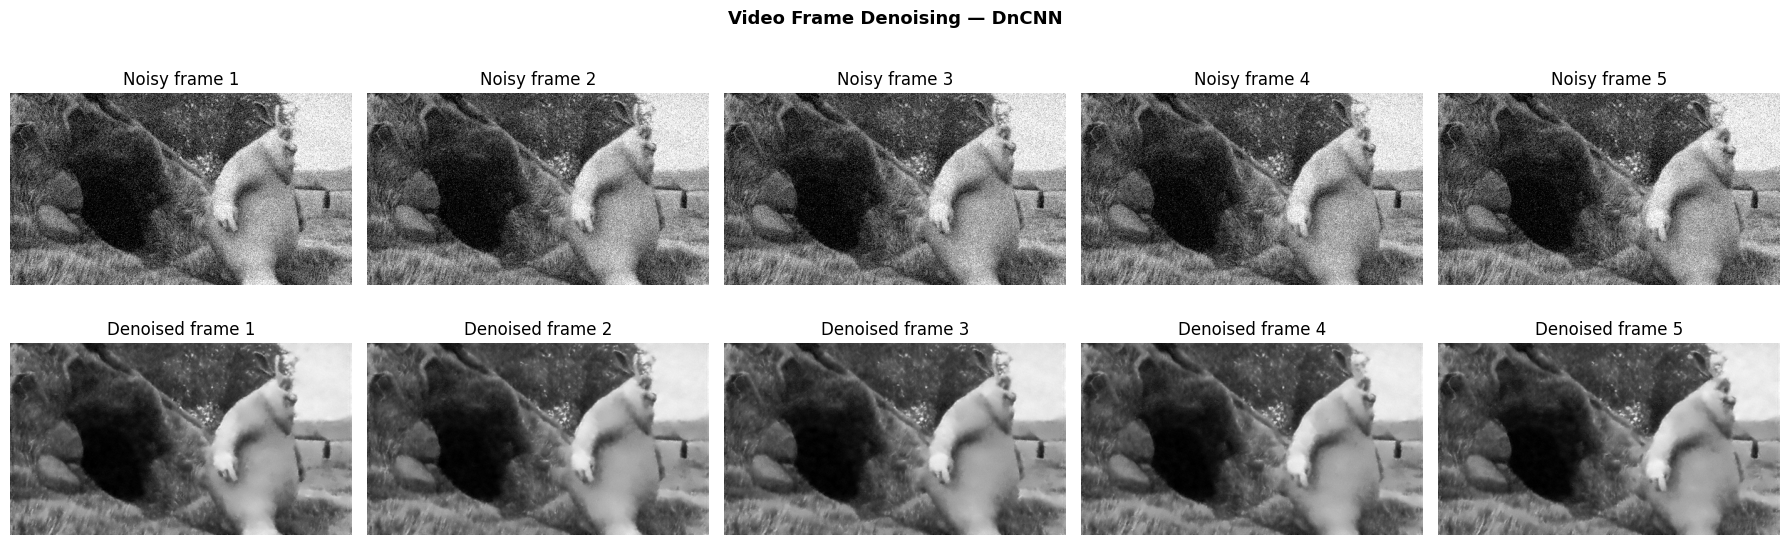

In [13]:
def process_video(input_path, output_path, model):
    """Read noisy video frame-by-frame, denoise with DnCNN, write MP4 output."""
    cap   = cv2.VideoCapture(input_path)
    fps   = cap.get(cv2.CAP_PROP_FPS)
    W     = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H     = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    tmp_out = '/tmp/denoised_raw.mp4'
    out = cv2.VideoWriter(tmp_out, cv2.VideoWriter_fourcc(*'mp4v'), fps, (W, H), isColor=False)

    denoised_preview = []
    noisy_preview    = []
    model.eval()

    for i in range(total):
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
        denoised = dncnn_denoise(model, gray)
        out.write((denoised * 255).astype(np.uint8))
        if i < 5:
            noisy_preview.append(gray)
            denoised_preview.append(denoised)

    cap.release()
    out.release()

    # Re-encode for proper H.264 playback
    os.system(f'ffmpeg -y -i {tmp_out} -vcodec libx264 -crf 23 -pix_fmt yuv420p {output_path} -loglevel quiet')
    print(f'Denoised video saved: {output_path}  ({total} frames)')
    return noisy_preview, denoised_preview

noisy_preview, denoised_preview = process_video(SYNTHETIC_VIDEO, DENOISED_VIDEO, model)

# ── Visualize sample frames ───────────────────────────────────────────────────
fig, axes = plt.subplots(2, 5, figsize=(18, 6))
for i in range(5):
    axes[0, i].imshow(noisy_preview[i],    cmap='gray')
    axes[0, i].set_title(f'Noisy frame {i+1}')
    axes[0, i].axis('off')
    axes[1, i].imshow(denoised_preview[i], cmap='gray')
    axes[1, i].set_title(f'Denoised frame {i+1}')
    axes[1, i].axis('off')
fig.suptitle('Video Frame Denoising — DnCNN', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 7 · Save & Load Model

In [14]:
# ── Save ──────────────────────────────────────────────────────────────────────
torch.save(model.state_dict(), 'dncnn_weights.pth')
print('Model saved to dncnn_weights.pth')

# ── Load (example) ────────────────────────────────────────────────────────────
# model_loaded = DnCNN(depth=17).to(DEVICE)
# model_loaded.load_state_dict(torch.load('dncnn_weights.pth', map_location=DEVICE))
# model_loaded.eval()

Model saved to dncnn_weights.pth
